# Sleep stages classification
___

This notebooks aims to explore the dataset [sleep-edf](https://physionet.org/content/sleep-edfx/1.0.0/) of _physionet_. We're only using the sleep cassettes and here's what we should know about that:
```
The 153 SC* files (SC = Sleep Cassette) were obtained in a 1987-1991 study of age effects on sleep in healthy Caucasians aged 25-101, without any sleep-related medication [2]. Two PSGs of about 20 hours each were recorded during two subsequent day-night periods at the subjects homes. Subjects continued their normal activities but wore a modified Walkman-like cassette-tape recorder described in chapter VI.4 (page 92) of Bob’s 1987 thesis [7].

Files are named in the form SC4ssNEO-PSG.edf where ss is the subject number, and N is the night. The first nights of subjects 36 and 52, and the second night of subject 13, were lost due to a failing cassette or laserdisk.

The EOG and EEG signals were each sampled at 100 Hz. The submental-EMG signal was electronically highpass filtered, rectified and low-pass filtered after which the resulting EMG envelope expressed in uV rms (root-mean-square) was sampled at 1Hz. Oro-nasal airflow, rectal body temperature and the event marker were also sampled at 1Hz.
```

We ultimatly want to discriminate sleep stages from recorded EEG data.

## Dependencies

Entropy, which is a Python library, must be installed with the following command:
```
pip install git+https://github.com/raphaelvallat/entropy
```

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.signal
import os

from collections import Callable, Counter
from datetime import datetime, timedelta
from entropy import entropy

import mne
from mne.datasets.sleep_physionet.age import fetch_data

## Data loading
____

Instead of downloading several times the dataset, we stock it once on our machine. We use the default path of mne, which is `~/mne_data/physionet-sleep-data`.

In [ ]:
SUBJECTS = range(20)
NIGHT_RECORDINGS = [1, 2]

subject_files = fetch_data(subjects=SUBJECTS, recording=NIGHT_RECORDINGS);

We also retrieve each patient information. We associate the same index as they are indexed within `subject_files`. Since we only have access to the first 20 patients data through MNE, we will discard patients information with an ID outside of that range.

When checking the `raw_data.info`, we can see that we have the property `raw_data.info["meas_date"]`, which represents the start date and time of the recording. We can then mark the moment of the signal where the lights were turned off.

In [ ]:
df_subject_information = pd.read_csv("data/SC-subjects.csv", delimiter=';')

df_subject_information = df_subject_information.rename(columns={"sex (F=1)": "sex"}, errors="raise")
df_subject_information = df_subject_information[df_subject_information["subject"].isin(SUBJECTS)]

df_subject_information['LightsOff'] =  pd.to_datetime(df_subject_information['LightsOff'], format='%H:%M')

df_subject_information.head(5)

## Channel exploration
___

We will explore the different channels for one subject's night. We will not look at the rectal temperature channel since we will not be able to get one ourself.


In [ ]:
RAW_DATA_FILE_INDEX = 0

raw_data = mne.io.read_raw_edf(subject_files[RAW_DATA_FILE_INDEX][0], preload=True, verbose=False)

NUMBER_CHANNELS = raw_data.info["nchan"]
LOWPASS_FILTER = raw_data.info["lowpass"]
SAMPLING_FREQ = raw_data.info["sfreq"]

print(raw_data)
print("The corresponding file has %i channels, has a low pass filter of %i Hz and a sampling rate of %i Hz." % (NUMBER_CHANNELS, LOWPASS_FILTER, SAMPLING_FREQ))
print("The channels are ", raw_data.info["ch_names"])
print(f"The recording is {raw_data.n_times/(3600 * SAMPLING_FREQ)} hours long.")

mapping = {'EEG Fpz-Cz': 'eeg',
           'EEG Pz-Oz': 'eeg',
           'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}

raw_data.set_channel_types(mapping)
raw_data.drop_channels('Temp rectal')
raw_data.set_annotations(mne.read_annotations(subject_files[RAW_DATA_FILE_INDEX][1]), emit_warning=False)

Because we cannot look at all the night's recording for all channels, since they have too many data points to be displayed and causes an error, we will look at the same subwindow of data for all channels.

In [ ]:
print(f"Nb stages transitions through the night: {len(raw_data.annotations)}")

print(f"Longest stage lasted {max(set(raw_data.annotations.duration))} seconds")
print(f"Shortest stage lasted {min(set(raw_data.annotations.duration))} seconds")

In [ ]:
def get_lights_off_timestamp(raw_data_info, file_index):
    """
    Returns a tuple in which there are:
        - the duration (in seconds) between the beginning of the recording and the time
            at which the subject turned off the lights.
        - the datetime at which the lights were turned off
    """

    raw_data_start_time = datetime.utcfromtimestamp(raw_data_info['meas_date'][0])
    raw_data_lights_off_time = df_subject_information.loc[file_index]['LightsOff']
    
    if raw_data_lights_off_time.time().hour < 12: # Fallen asleep after midnight
        lightoff_date = raw_data_start_time.date() + timedelta(days=1)
    else:                                         # Fallen asleep before midnight
        lightoff_date = raw_data_start_time.date()
        
    raw_data_lights_off_time = raw_data_lights_off_time.replace(year=lightoff_date.year, month=lightoff_date.month, day=lightoff_date.day)

    return ((raw_data_lights_off_time - raw_data_start_time).total_seconds(), raw_data_lights_off_time)

lights_off_second, _ = get_lights_off_timestamp(raw_data.info, RAW_DATA_FILE_INDEX)

print(f"Subject closed the light {lights_off_second/3600:.3f} hours after the recording started.")

In [ ]:
def find_last_non_wake_annotation(annotations, timestamps):
    scores_with_timestamp = list(zip(annotations, timestamps))

    return next((time for (stage, time) in reversed(scores_with_timestamp) if stage not in ['Sleep stage W', 'Sleep stage ?', 'Movement time']), None)

last_non_wake_second = find_last_non_wake_annotation(raw_data.annotations.description, raw_data.annotations.onset)

print(f"Subject woke up {last_non_wake_second/3600:.3f} hours after the recording started.")

In [ ]:
# DURATION = 30000.0
# START_WINDOW = 24000

DURATION = last_non_wake_second - lights_off_second
START_WINDOW = lights_off_second

### EEG Channel
___

Electrode placement for this dataset was choosen along the midline axis. We have a **bipolar electrode montage**, which means that you have two electrodes per one channel, so you have a reference electrode for each channel.

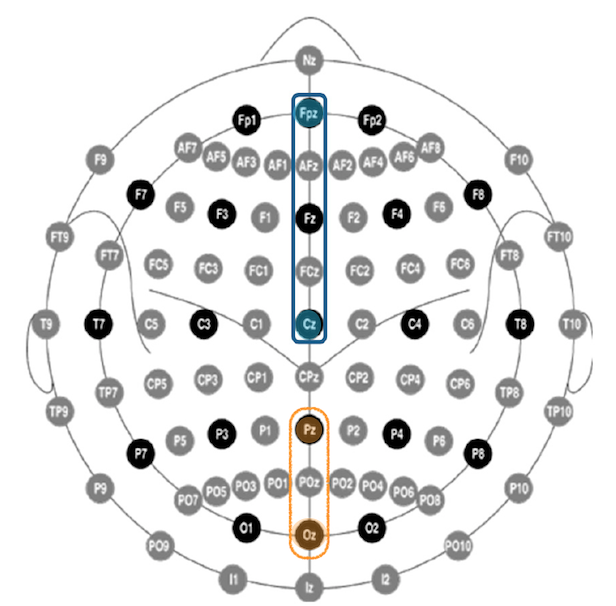

#### Fpz-Cz Channel
____

As its name states, it is an eeg signal with the electrode placed on the forehead and its reference placed on top of the head. Both are centered. They can be seen above in the blue rectangle.

In [ ]:
raw_data.copy().pick('EEG Fpz-Cz').plot(butterfly=True, duration=DURATION, start=START_WINDOW);

#### Pz-Oz Channel
____

We can see the electrodes located at the back of the head follow the same pattern as with the other channel. The electrode montage for this channel is represented in orange in the figure above. 

In [ ]:
raw_data.copy().pick('EEG Pz-Oz').plot(butterfly=True, duration=DURATION, start=START_WINDOW);

We can then compare the PSD plot from both channels. We can see the general amplitude of the **EEG Fpz-Cz** channel is greater than the amplitude of the **EEG Pz-Oz** channel.

In [ ]:
raw_data.copy().pick(['EEG Fpz-Cz','EEG Pz-Oz']).plot_psd(tmin=START_WINDOW, tmax=START_WINDOW+DURATION);


We keep both EEG channels because the goal of the classification is to use them as a way to distinguish sleep stages.

### EOG Channel
____

This channel is a horizontal EOG signal, with electrodes placed on both outer corners of the eyes, as you can see [here](https://www.researchgate.net/figure/Typical-EOG-electrode-placements-for-Horizontal-and-Vertical-channels_fig1_40452196).

In [ ]:
raw_data.copy().pick('EOG horizontal').plot(butterfly=True, duration=DURATION, start=START_WINDOW);

#### Eye movemnent artifact on EEG Channels
____

As it is described in this [tutorial](https://mne.tools/stable/auto_tutorials/preprocessing/plot_10_preprocessing_overview.html#ocular-artifacts-eog), we can detect epochs that contain artefact of eye movement by looking at the EOG signal.

The result of the below operations center all epochs of the EEG channels around the eye movement artefact.

In [ ]:
eog_epochs = mne.preprocessing.create_eog_epochs(raw_data)


In [ ]:
eog_epochs.plot_image(combine='mean')


Even though the EOG signal is very useful to discriminate REM stage from the S1 stage [[source]](https://en.wikipedia.org/wiki/Polysomnography#Mechanism), we will not include it in our classifier, because we want to keep the montage simple for the end user.

### Chin EMG Channel
____

We finally also have a EMG channel to detect muscle movement near the mouth. We can see the electrodes are sort of placed as below:

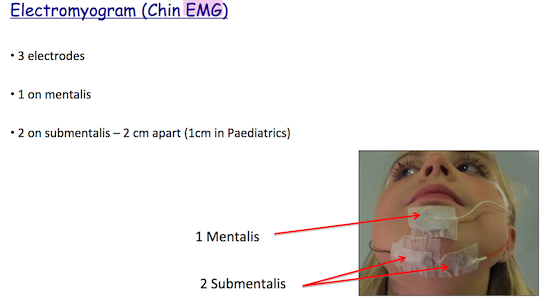

In [ ]:
raw_data.copy().pick('EMG submental').plot(butterfly=True, duration=DURATION, start=START_WINDOW);

For the same reason as with the EOG signal, which was to keep the montage simple, we will not use this signal for the classification.

### Event marker
____

It has a sampling rate of 1hz. This channel doesn't have a proper description, so we cannot interpret its meaning. We therefore ignore it.

In [ ]:
raw_data.copy().pick('Event marker').plot(duration=DURATION, start=START_WINDOW);

raw_data.drop_channels(['Event marker'])

# Recording exploration
___
We currently have **39 night recordings** of 20 subjects. Because we have a limited capacity in terms of memory, we will have to discard some part of the recorded signal. As we've seen in the previous section, files contain a whole day of recording.

We will then discard all recorded signal before the subject turned the lights off and all of the signal after the subject has awaken in the morning. We have to still analyze how many hours of recording we will have left.

We will keep this information in our dataframe, where we define **NightDuration** as the timespan, in seconds, inbetween the time at which the subject closed the lights and the time at which the subject had their last non-wake sleep stage scored.

In [ ]:
start_times = []
lights_off_times = []
lights_off_seconds = []
night_durations = []

for file_index in range(len(subject_files)):

    data = mne.io.read_raw_edf(subject_files[file_index][0], preload=False, verbose=False)
    data.set_annotations(mne.read_annotations(subject_files[file_index][1]), emit_warning=False)
        
    light_off_seconds, light_off_time = get_lights_off_timestamp(data.info, file_index)
    last_non_wake_seconds =  find_last_non_wake_annotation(data.annotations.description, data.annotations.onset)

    night_durations.append(last_non_wake_seconds - light_off_seconds)
    lights_off_times.append(light_off_time)
    lights_off_seconds.append(light_off_seconds)
    start_times.append(datetime.utcfromtimestamp(data.info['meas_date'][0]))
    
    assert (last_non_wake_seconds - light_off_seconds) % 30 == 0, "Must respect epoch size"
    
df_subject_information['StartRecord'] = start_times
df_subject_information['LightsOff'] = lights_off_times
df_subject_information['LightsOffSecond'] = lights_off_seconds
df_subject_information['NightDuration'] = night_durations

df_subject_information.head(5)

In [ ]:
print(f"Hours of recording: {df_subject_information['NightDuration'].sum()/3600:.3f}")
print(f"Nb of 30s epochs: {df_subject_information['NightDuration'].sum()/30}")

We then check if any file contains unusual information.

In [ ]:
plt.xlabel("Number of hours in bed")
plt.ylabel("Number of occurences")
plt.hist([x/3600 for x in df_subject_information['NightDuration']]);

The earliest time at which a subject went to sleep is at about 10 o'clock.

In [ ]:
plt.xlabel("Hour at which the user closed the lights")
plt.ylabel("Number of occurences")
plt.hist([x.time() for x in df_subject_information['LightsOff'] if x.hour > 12]);

The later time at which a subject went to sleep is at about 1:45.

In [ ]:
plt.hist([x.time() for x in df_subject_information['LightsOff'] if x.hour < 12]);

All of the processed information looks good.


# Preprocessing
___

We're using an arbitrary 30 seconds window to create our epochs. We think it should be long enough to get an overview of what is the sleep stage. Also, we're merging the stage 3 and stage 4 into a stage 3/4, because it is the  American Academy of Sleep Medicine official standard since 2007 which is widely used in PSG and hypnograms in general.

## Data cleansing
___

We do not need to proceed to any particular data cleansing, since the technician who tagged our data, already did the job. We just need to ignore epochs without a sleep stage tag. These usually have the `?` marker, that correponds to an epoch that could not be classified. We also ignore epochs tagged with a `M`, which means the subject was moving while sleeping. We then just analyze epochs which were manually tagged as a valid sleep stage by the technician.

In [ ]:
EPOCH_DURATION = 30. # in seconds

ANNOTATIONS_EVENT_ID = {
    'Sleep stage W': 0,
    'Sleep stage 1': 2,
    'Sleep stage 2': 3,
    'Sleep stage 3': 4,
    'Sleep stage 4': 4,
    'Sleep stage R': 5,
    'Sleep stage ?': 6,
    'Movement time': 7
}

EVENT_ID = {
    'Sleep stage W': 0,
    'Sleep stage 1': 2,
    'Sleep stage 2': 3,
    'Sleep stage 3/4': 4,
    'Sleep stage R': 5,
    'Sleep stage ?': 6,
    'Movement time': 7
}

MAX_TIME = EPOCH_DURATION - 1. / SAMPLING_FREQ  # tmax in included

## Epoching
___
The following code create the epochs and store the files on the local computer. We should run it once.

In [ ]:
def get_epochs(number_files, use_all_events=True, equalize_event_counts=False):

    all_subject_epochs = []

    for i in range(number_files):
        print(f"Retrieving file no.{i}")
        # 1. get all epochs of one person
        raw_data = mne.io.read_raw_edf(subject_files[i][0], preload=True, verbose=False, exclude=["Temp rectal", "Event marker", "Resp oro-nasal", "EMG submental", "EOG horizontal"])

        # 2. add the sleep stage annotation to the raw data
        annotations = mne.read_annotations(subject_files[i][1])
        raw_data.set_annotations(annotations, emit_warning=False)

        # 3. only keep event ids present in the current file
        event_ids = EVENT_ID.copy()
        annotations_events = ANNOTATIONS_EVENT_ID.copy()
        if 'Movement time' not in np.unique(annotations.description) or not use_all_events:
            annotations_events.pop('Movement time', None)
            event_ids.pop('Movement time', None)
            
        if not use_all_events:
            annotations_events.pop('Sleep stage ?', None)
            event_ids.pop('Sleep stage ?', None)

        # 4. transform into epochs
        events, _ = mne.events_from_annotations(raw_data, event_id=annotations_events, chunk_duration=EPOCH_DURATION, verbose=False)
        df = pd.DataFrame()
        df = df.append([df_subject_information.loc[[i]]] * len(events))
        try:
            epochs = mne.Epochs(raw=raw_data, events=events, event_id=event_ids, tmin=0., tmax=MAX_TIME, baseline=None, verbose=False, metadata=df)
        except ValueError as e:
            # If no ? epochs are created, we need to ignore this class
            event_ids.pop('Sleep stage ?', None)
            epochs = mne.Epochs(raw=raw_data, events=events, event_id=event_ids, tmin=0., tmax=MAX_TIME, baseline=None, verbose=False, metadata=df)

        if equalize_event_counts:
            epochs.equalize_event_counts(event_ids.keys())

        all_subject_epochs.append(epochs)

    print("Concatenating all epochs together...")
    return mne.concatenate_epochs(all_subject_epochs)

In [ ]:
USE_ALL_EVENTS = False

In [ ]:
# ## Comment the following code if you already saved the epochs into a .fif file.
FILE_NAME = "data/10-data-epo.fif" 
if not os.path.isfile(FILE_NAME): 
    epochs = get_epochs(number_files=10, use_all_events=USE_ALL_EVENTS, equalize_event_counts=True)
    epochs.save("FILE_NAME")

Then, we can retrieve the epochs from the saved file.

In [ ]:
epochs = mne.read_epochs("data/10-data-epo.fif")
epochs 

# Sleep stage visualization
___

We explore an example of an epoch of each sleep stage in the time domain in order to get an idea of our data.



In [ ]:
EEG_CHANNELS = ['EEG Fpz-Cz','EEG Pz-Oz']

In [ ]:
NROWS = len(EVENT_ID.keys()) if USE_ALL_EVENTS else len(EVENT_ID.keys()) - 2

for j, channel in enumerate(EEG_CHANNELS):
    fig, ax = plt.subplots(nrows=NROWS, figsize=(16,18))
    fig.suptitle(f"Sample epochs for {channel}")
    plt.xlabel("time (s)")

    fig.tight_layout()
    for i in range(NROWS):
        stage = list(EVENT_ID.keys())[i]
        data = epochs[stage][0].get_data().squeeze()
        x = np.linspace(0.0, EPOCH_DURATION, len(data[j]))
        current_ax = ax[i]
        current_ax.plot(x, data[j])
        current_ax.set_title(f"{stage} sample epoch")
        current_ax.set_ylabel("amplitude (uV)")
    fig.show()


We can conclude that the `Sleep stage ?` and `Movement time` tags correspond to the data cleansing that was made by the technician. No need for fancy data cleansing!

We just drop both events from the epochs.

In [ ]:
events = list(epochs.event_id.keys())
if 'Movement time' in events:
    events.remove('Movement time')
if 'Sleep stage ?' in events:
    events.remove('Sleep stage ?')

epochs = epochs[events]


## Analyzing PSD of epochs grouped by sleep stage score
____

We want to check if power band amplitudes change depending on the epoch's sleep stage class. We will then take all epochs with the same classification and then display their respective PSD.

The power spectrum density is meaningful only for stationary signals. Since our EEG data is not a stationary signal, we'll use the Welch's method to estimate the PSG. The Welch's method is a simple method to estimate PSG by calculating an EEG for smaller windows on our epoch. Then, these PSDs are averaged in order to get an idea of the PSG of the entire epoch. The tradeoff of doing so is a decrease in frequency resolution, but more precision on the PSD.

In [ ]:
epochs_df = epochs.to_data_frame(long_format=True, picks="eeg")
epochs_df.drop(columns='ch_type')

In [ ]:
epochs_df.head()

In [ ]:
epoch_events = epochs_df[['epoch', 'condition']].drop_duplicates(keep="first").set_index('epoch')['condition'].to_numpy()
epoch_events

We will use the [0.5, 30] Hz frequency band. **# TODO: Justify**

We're using the Welch's method in order to get a more accurate psd of our full 30 seconds epoch. Remember that EEG signals are not stationary and therefore, it is important to use Welch's method.

In [ ]:
# psds will be of shape (n_epochs, n_channels, n_freqs) i.e. 8281 epochs x 2 channel x 75 freq

psds, freqs = mne.time_frequency.psd_welch(epochs, picks=EEG_CHANNELS, fmin=0.5, fmax=30.)

scaling = 1e6 # see here for default eeg scaling using for plotting (i.e. plot_psd): https://github.com/mne-tools/mne-python/blob/c437ed0bbcef3b6bf3a8beab2221ab5bff47722f/mne/defaults.py#L20 
psds *= scaling * scaling
np.log10(np.maximum(psds, np.finfo(float).tiny), out=psds)
psds *= 10

In [ ]:
len(freqs)

In [ ]:

'''
ce qu'on voudrait serait un dataframe avec les colonnes suivantes
(pareil à epochs_df, sauf dans domain frequency avec psd):

- sleep-stage: event_id
- epoch: no de l'epoch
- frequency: fréquence issu de `freqs` (similaire à `time`de epochs_df)
- channel: EEG Fpz-Cz ou EEG Pz-Oz
- psd: valeur issue de `psds`

'''
psds_df_dict = { "stage": [],  "epoch": [], "frequency": [], "channel": [], "psd": [] }
NO_FREQS = len(freqs)

for no_epoch in range(len(psds)):
    current_sleep_stage = epoch_events[no_epoch]

    for no_channel in range(len(EEG_CHANNELS)):
        current_channel = EEG_CHANNELS[no_channel]
        
        psds_df_dict["stage"].extend([current_sleep_stage] * NO_FREQS)
        psds_df_dict["epoch"].extend([no_epoch] * NO_FREQS)
        psds_df_dict["channel"].extend([current_channel] * NO_FREQS)

        psds_df_dict["frequency"].extend(freqs)
        psds_df_dict["psd"].extend(psds[no_epoch][no_channel])


In [ ]:
epoch_psds_df = pd.DataFrame(psds_df_dict)
epoch_psds_df

### Show mean psd
___

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=(16, 16))

def plot_mean(x, y, name, ax, percentile=None):
    """ This function plot a channel line according"""
    calculation_df =  y.agg(['mean', 'std'])
    ax.plot(calculation_df.index, calculation_df['mean'], label=name)
    if percentile is 'std':
        ax.fill_between(x=x, y1=calculation_df['mean']+calculation_df['std'], y2=calculation_df['mean']-calculation_df['std'], alpha=0.2)
    elif percentile is 'range':
        lower_bound = y.quantile(0)
        upper_bound = y.quantile(1)
        ax.fill_between(x=x, y1=lower_bound, y2=upper_bound, alpha=0.2)
    elif percentile:
        if not 0 <= percentile <= 1:
            raise ValueError('percentile must be std or in the [0, 1] range')
        alpha = 1 - percentile
        lower_bound = y.quantile(alpha/2)
        upper_bound = y.quantile(1-(alpha/2))
        ax.fill_between(x=x, y1=lower_bound, y2=upper_bound, alpha=0.2)

def plot_stages_mean_psd(df, channel, ax, percentile=None):
    stages_psds = {stage: epoch_psds_df.query(f"channel == '{channel}' & stage == '{stage}'").groupby('frequency').psd for stage in epoch_psds_df.stage.unique()}
    freqs = epoch_psds_df.frequency.unique()
    for stage, psds in stages_psds.items():
        plot_mean(freqs, psds, stage, ax, percentile=percentile)
    ax.legend()
    title = f"Mean PSD according to each sleep stage for {channel}"
    title = title + f" within {percentile} of the data" if percentile else title
    ax.set_title(title)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power Spectral Density (uV2/Hz)')

plot_stages_mean_psd(epoch_psds_df, 'EEG Fpz-Cz', ax[0], percentile='std')
plot_stages_mean_psd(epoch_psds_df, 'EEG Pz-Oz', ax[1], percentile='std')

### What we see
___

When looking at the standard deviation of the psds datapoints of the Pz-Oz channel, we can see that some are not overlapping a lot which is great news for future sleep stage classification. For example, at the beggining of the spectrum, sleep stage 3/4 can be clearly discriminated from the other stages. At the end of the spectrum (highest freqs), we can see that wake can be discriminated from sleep.
### With 95% most common values
___

We can use the range of the 95% most common values in order to have an idea of the range of the psd observations without the most obvious outliers.

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=(16, 16))

plot_stages_mean_psd(epoch_psds_df, 'EEG Fpz-Cz', ax[0], percentile=0.95)
plot_stages_mean_psd(epoch_psds_df, 'EEG Pz-Oz', ax[1], percentile=0.95)

### What we see
___
In this plot, we can see that deep sleep is linked to more power into slow waves and that wake stages are linked to more power at high frequencies.

Also, we suspect that the little hill between 11 and 16 Hz for sleep stage 2 is caused by spindles. However, we think we need a better detection method for the spindles, since it will not be easy to discriminate from the other stages.

Also, we can see that the range of the values for the psd of each stage is overlapping with each other wich seems to makes it harder to discriminate a stage with another.

It would be better to get an idea of the distribution of the psd, in order to know if we can discriminate these. To get an essence of the full distribution, we will calculate the relative power for each frequency band (delta, theta, alpha, beta, gamma) as often used in EEG experiments. Then, we'll plot a violin for each relative band power.

### Average band power
___

Average band power can simply obtained by integrating our psd for each frequency band. To numerically calculate our integral, we can calculate the sum of our psd data points for each frequency band.

First, we need to define our frequency bands

In [ ]:
FREQ_BANDS = {
    "delta": [0.5, 4.5],
    "theta": [4.5, 8.5],
    "alpha": [8.5, 11.5],
    "sigma": [11.5, 15.5],
    "beta": [15.5, 30]
}

Then, we need to find calculate the power of each of these 5 frequency bands for every epochs we have.

In [ ]:
def add_labels_on_plot(ax, stages):
    ax.set_xticks(np.arange(1, len(stages) + 1))
    ax.set_xticklabels(stages)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('Sleep stage')
    ax.set_ylabel('Power uV^2/Hz')

def plot_average_band_power_per_chan(df, ax, channel, stages, band, fmin, fmax):
    X = []
    for stage in stages:
        stages_psds = df.query(f"channel == '{channel}' & stage == '{stage}'")
        stages_psds = stages_psds[fmin < stages_psds.frequency]
        stages_psds = stages_psds[fmax >= stages_psds.frequency]
        x = stages_psds.groupby('epoch').psd.agg(['sum'])
        X.append(x.to_numpy().squeeze())

    ax.set_title(f"Average frequency power for the {band} band [{fmin}, {fmax}]")
    ax.violinplot(X, showmeans=True)
    add_labels_on_plot(ax, stages)

def plot_average_band_power(df, channel):
    fig, ax = plt.subplots(nrows=len(FREQ_BANDS),figsize=(16, 16))
    stages = df.stage.unique()
    for i, (band, (fmin, fmax)) in enumerate(FREQ_BANDS.items()):
        plot_average_band_power_per_chan(df, ax[i], channel, stages, band, fmin, fmax)

    plt.tight_layout()
    fig.suptitle(f"Average frequency power for each power band for the {channel} channel", fontsize=18, fontweight='bold', y=1.05)

In [ ]:
plot_average_band_power(epoch_psds_df, 'EEG Fpz-Cz')

In [ ]:
plot_average_band_power(epoch_psds_df, 'EEG Pz-Oz')

## Analyzing time domain features
___

Time domain features are easy to extract and can hold some information about the current sleep stage the subject is in. Moreover, manual sleep stage scoring is mostly realized only on the time domain EEG epochs, which indicates it is possible to select valuable time domain features.

### a. Standard statistics
___

The first features we will explore are the statiscical moments of each epoch. **Moments are a set of statistical parameters to measure a distribution**. In our case, we are looking at the distribution of the amplitudes (microVolt) accross all 30s epochs grouped by EEG channel and by sleep stage.

According to Koley [[1]](https://www.sciencedirect.com/science/article/pii/S0010482512001588?via%3Dihub#bib36), the statistical parameters can be used as features in order to classify sleep stages:

 > Among the various statistical properties of the EEG time series, the first- to fourth-order moments have already been used in preceding studies [28], [29], [32]. **The variance of EEG (M2) was found suitable for discriminating REM sleep from S2 and SWS [29].** These first- to fourth-order statistical parameters i.e., mean (M1), variance (M2), skewness (M3) and kurtosis (M4) were computed for the EEG epoch X(n) to quantify the central tendency, degree of dispersion, asymmetry and peakedness, respectively. These measurements were calculated using the formulas given in [36].
 
For each epoch and for each EEG channel, we want to look if we can discriminate the sleep stages with the following parameters: mean, variance, skewness and kurtosis.

***Note on how to read the following figures:***
The mean of the parameter is represented by the middle horizontal trait. The shape of the distribution of the parameter is represented by the blue area. Finally, the vertical bar represents the 100% confidence interval (range) of the calculated parameter. There is a calculation of the parameter for each epoch.

In [ ]:
def plot_time_domain_distribution(epochs_df, measure_type, unit_label=""):
    fig, ax = plt.subplots(nrows=2,figsize=(16,10))
    stages = epochs_df.condition.unique().astype(str)
    print(f"The ordered violins are for: {stages}")

    for i, channel in enumerate(epochs_df['channel'].unique()):
        stats_epoch_df = epochs_df \
            .query(f"channel == '{channel}'") \
            .sort_values(by=['epoch','time']) \
            .groupby('epoch') \
            .agg({'condition': 'first', 'observation': measure_type})

        ax[i].violinplot([stats_epoch_df.query(f"condition == '{stage}'").observation.values for stage in stages], showmeans=True)
        ax[i].set_title(f"Distribution of the {measure_type} signal for {channel}")
        ax[i].set_ylabel(unit_label)
        ax[i].set_xticks(np.arange(1, len(stages) + 1))
        ax[i].set_xticklabels(stages)

    plt.show()

#### I - Distribution of the mean of the signal
___

We plot the distribution of the mean values of all epochs. We can see the mean value of the mean time domain signal is generally the same within all epochs of the same observed channel (i.e. 0.4 uV for the Fpz-Cz channel and 0.25 uV for the Pz-Oz channel).

We can also see the distribution of the mean are generally the same within the same channel, whereas we have two normal distribution, closer in the first channel and more apart in the second channel. They are not quite aligned, which could be discriminating. It could be interesting to look at what causes this seperation in two normal distributions.

For those reasons, it is reasonable to assume the added information could be a bit significant.

In [ ]:
plot_time_domain_distribution(epochs_df, measure_type='mean', unit_label="uV")

#### II - Distribution of the standard deviation of the signal
___

We plot the distribution of the standard deviation values of all epochs. We can see the mean value of the standard deviation of the time domain signal is quite different accross the different sleep stages, as we expected from the stated paper from Koley.

We can therefore expect the standard deviation of a time domain signal to discriminate the sleep stage classification.

In [ ]:
plot_time_domain_distribution(epochs_df, measure_type='std', unit_label="uV^2")

#### III - Distribution of the skewness of the signal
___

We plot the distribution of the skewness value of all epochs. As with the distribution of the mean signal, whereas the mean and the distribution form is quite the same accross sleep stage scores, we assume the added information of this parameter is probably not significant.

Note: skewness does not have a unit [[source]](https://brownmath.com/stat/shape.htm).

In [ ]:
plot_time_domain_distribution(epochs_df, measure_type='skew')

#### IV - Distribution of the kurtosis of the signal
___

We plot the distribution of the kurtosis value of all epochs. The same can be conclude as with the skewness, for the same observed reasons.

Note: kurtosis does not have a unit [[source]](https://brownmath.com/stat/shape.htm).

In [ ]:
from scipy.stats import kurtosis

plot_time_domain_distribution(epochs_df, measure_type=kurtosis)

### b. Zero crossing rate
___

It is defined as the number of time the signal crosses the reference line, which, in our case, is the mean. For each epoch, we will compute the number of time two consecutive data points lies apart of the line determined by the mean. The zero crossing rate is said to be able to distinguish sleep spindles, which are observed during sleep stage 2 [[source]](https://doi.org/10.1016/j.compbiomed.2012.09.012). 



In [ ]:
def get_crossing_rate_with_windows(epoch_observations, nb_windows_per_epoch=15):
    """
    Calculates the median crossing rate for `nb_windows_per_epoch` subwindows within a 30s epoch.
    Returns the maximum crossing rate accross all subwindows.
    
    epoch_observations: All data points are expected to be consecutive in time,
        and correspond to all observed potentials (uV) within a 30s epoch.
    nb_windows_per_epoch: Specify how many subwindows to check within the 30s epochs
    """
    nb_points_per_window = len(epoch_observations)/nb_windows_per_epoch # Nb of points in each two second window
    mean_value = epoch_observations.mean()
    cross_occurences = [0]*nb_windows_per_epoch
    
    for i, (first, second) in enumerate(zip(epoch_observations, epoch_observations[1:])):
        if (first > mean_value and second < mean_value) or \
           (first < mean_value and second > mean_value):
            cross_occurences[int(i//nb_points_per_window)] += 1
    
    return np.max(cross_occurences)

def get_crossing_rate(epoch_observations):
    """
    Calculates the median crossing rate for a 30s epoch.
    
    epoch_observations: All data points are expected to be consecutive in time,
        and correspond to all observed potentials (uV) within a 30s epoch.
    """
    mean_value = epoch_observations.mean()
    cross_occurences = 0
    
    for first, second in zip(epoch_observations, epoch_observations[1:]):
        if (first > mean_value and second < mean_value) or \
           (first < mean_value and second > mean_value):
            cross_occurences += 1
    
    return cross_occurences

In [ ]:
%%time

plot_time_domain_distribution(epochs_df, measure_type=get_crossing_rate, unit_label="Nb of times the signal crossed median")

In [ ]:
plot_time_domain_distribution(epochs_df, measure_type=get_crossing_rate_with_windows, unit_label="Nb of times the signal crossed median")

We can see this parameter discriminate epochs according to their sleep stages, because the mean doesn't overlap. It may not be significant as to describe epochs when the subject is awake, because the distribution looks flat.

### c. Hjorth parameters
___

Hjorth parameters are often used as features to describe EEG signals (via wiki). The formulas are taken from this paper [[source]](https://www.doi.org/10.1155/2011/406391) and this paper [[source]](https://www.doi.org/10.1109/TBME.2005.869773). They are calculated on all of the 30s epoch. The parameters are:

- Hjorth activity

    Corresponds to the signal power, whereas the variance of the signal. It was already observed at section 1.a.

- Hjorth mobility

$$mobility = \sqrt{\frac{\sigma(\bf{x}')}{\sigma(\bf{x})}} = \sqrt{\frac{\sum{(x_i - x_{i-1})}/N}{\sum{(x_i)}/N}}$$    
    
- Hjorth complexity

$$complexity = \frac{mobility(\bf{x}')}{mobility(\bf{x})} = \frac{\sqrt{\sum{(x_i - 2x_{i-1} + x_{i-2})^2\sum{x_i}}}}{\sum{(x_i - x_{i-1})}}$$


In [ ]:
# Code took from https://github.com/forrestbao/pyeeg/blob/master/pyeeg/hjorth_mobility_complexity.py
# to calculate hjorth parameters

def get_hjorth_mobility(signal):
    """
    Calculates the hjorth mobility for a 30s epoch.
    
    signal: All data points are expected to be consecutive in time,
        and correspond to all observed potentials (uV) within a 30s epoch.
    """
    signal = signal.tolist()
    differential_signal = np.diff(signal).tolist()
    
    differential_signal.insert(0, signal[0])  # pad the first difference
    differential_signal = np.array(differential_signal)

    n = len(signal)

    M2 = float(sum(differential_signal ** 2)) / n
    TP = sum(np.array(signal) ** 2)

    return np.sqrt(M2 / TP)

def get_hjorth_complexity(signal):
    """
    Calculates the hjorth mobility for a 30s epoch.
    
    signal: All data points are expected to be consecutive in time,
        and correspond to all observed potentials (uV) within a 30s epoch.
    """
    signal = signal.tolist()
    differential_signal = np.diff(signal).tolist()
    
    differential_signal.insert(0, signal[0])  # pad the first difference
    differential_signal = np.array(differential_signal)

    n = len(signal)

    M2 = float(sum(differential_signal ** 2)) / n
    TP = sum(np.array(signal) ** 2)

    M4 = 0
    for i in range(1, len(differential_signal)):
        M4 += (differential_signal[i] - differential_signal[i - 1]) ** 2
    M4 = M4 / n

    return np.sqrt(float(M4) * TP / M2 / M2)

In [ ]:
%%time

plot_time_domain_distribution(epochs_df, measure_type=get_hjorth_mobility)

In [ ]:
%%time

plot_time_domain_distribution(epochs_df, measure_type=get_hjorth_complexity)

Both parameters seem discriminating, notably the mobility for the second channel. However, with the current implementation, the calculation of the hjort complexity can take time, even with a small number of epochs. 

## Analyzing non-linear features
___

Without the EOG channel as an input to our classifier, sleep stages that are the hardest to distinguish are the REM and sleep stage 1. As it is mentionned in this article [[source]](https://doi.org/10.1016/j.compbiomed.2012.09.012), they can be discriminated with the following features:

> The non-linear parameters ApEn and LZC found to be effective in distinguishing between the two hardly distinguishable stages: S1 and REM.

We chose to use ApEn since it is more used in automatic sleep stage score than LZC [[source]](https://www.doi.org/10.3390/e18090272).

### Approximate entropy
___

As with Shannon entropy, this feature discribes the "randomness" of the signal, the disorder or uncertainty of the values that compose the signal. On the other hand, the difference between Shannon and Approximate entropies is that the first considers the distribution of the signal, whereas the latter observes sequence reccurence [[source]](https://doi.org/10.3389/fninf.2013.00033). It is then more appropriate to use approximate entropy on signals of shorter lengths.


I also used `entroPy` to calculate ApEn.

The basic algorithm to calculate ApEn is O(N^2), which is quite long. I've found [this paper](https://doi.org/10.1016/j.cmpb.2008.02.008), which includes a good definition of the feature, that reduces the compute time, which could be useful if we include this feature.

Approximate entropy uses three parameters:
- Window size $m$
       
    Defines the length of the subwindows that will be compared. According to [this paper](https://www.frontiersin.org/articles/10.3389/fninf.2013.00033/full), the suggested value for EEG signals found accross multiple other papers is **2**.
- Distance $r$

    Defines the minimum distance between two data points to be considered *similar*. We set it to 0.2 times the standard deviation of the signal; $r = 0.2*\sigma(X)$.

- Total signal length $N$

    Defines the length of the entire observed signal. It typically is between 75 and 5000 [[source]](http://doi.org/10.1177/155005940503600106). In our case, we have $N = 100 hz *30s = 3000$, which is normal.

In [ ]:
def get_approximate_entropy(signal):
    """
    Calculates the approximate entropy for a 30s epoch.
    
    signal: All data points are expected to be consecutive in time,
        and correspond to all observed potentials (uV) within a 30s epoch.
        
    By using the entroPy library, we cannot set the `r` parameter. Though, it uses the same definition
    as we expected to use, because it was conceived to be used for EEG signals.
    """
    signal = signal.to_numpy()

    M = 3

    return entropy.app_entropy(signal, order=M)

In [ ]:
%%time

plot_time_domain_distribution(epochs_df, measure_type=get_approximate_entropy)

In [ ]:
%%time
plot_time_domain_distribution(epochs_df, measure_type=lambda signal: entropy.sample_entropy(signal, order=2))

# δ, θ, α, β and γ frequency band decomposition
___

We'll apply 5 butterworth band-pass filters on our time series.

In [ ]:
NYQUIST_FREQ = SAMPLING_FREQ/2
WOR_N = 512

epochs_sub_bands = dict.fromkeys(FREQ_BANDS.keys())
kernels = dict.fromkeys(FREQ_BANDS.keys())

for key, freq_range in FREQ_BANDS.items():
    fig, ax = plt.subplots(figsize = (16, 8))
    lower_bound = freq_range[0]/NYQUIST_FREQ
    upper_bound = freq_range[1]/NYQUIST_FREQ
    hz = np.linspace(0, NYQUIST_FREQ, WOR_N)
    ideal_filter = [1 if freq_range[0] <= f <= freq_range[1] else 0 for f in hz]
    ax.plot(hz, ideal_filter, label="Ideal filter")
    kernels[key] = {}
    for order in range(3, 10):
        b, a = scipy.signal.butter(order, [lower_bound, upper_bound], btype='bandpass')
        w, h = scipy.signal.freqz(b, a, worN=WOR_N)
        ax.plot(hz, abs(h), label=f"Order {order}")
        ax.set_ylim([0, 1.5])
        ax.set_xlim([freq_range[0] - 5, freq_range[1] + 5])
        kernels[key][order] = (b, a)

    ax.legend()
    ax.set_title(f"Frequency response of different orders for passband {key} {freq_range} Hz")
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Gain")
    plt.show()

We then choose the order that has the the best frequency response for each of our bandpass.

In [ ]:
%%time
ORDERS = {
    'delta': 5,
    'theta': 8,
    'alpha': 9,
    'sigma': 9,
    'beta': 9
}

Let's use mne to apply this filter directly on the epochs object.

In [ ]:
%%time
for key, freq_range in FREQ_BANDS.items():
    l_freq = freq_range[0]/NYQUIST_FREQ
    h_freq = freq_range[1]/NYQUIST_FREQ
    b = kernels[key][ORDERS[key]][0]
    a = kernels[key][ORDERS[key]][1]
    epochs_sub_bands[key] = epochs.copy().filter(l_freq=l_freq, h_freq=h_freq, method='iir', n_jobs=-1, iir_params = {'order': order, 'ftype': 'butter','a': a,'b': b}, verbose=False)

In [ ]:
fig, ax = plt.subplots(figsize=(19,6))

original_epoch = epochs['Sleep stage W'][0].get_data().squeeze()[0]
x = np.linspace(0.0, EPOCH_DURATION, len(original_epoch))
ax.plot(x, original_epoch)

reconstituted_signal = np.zeros(len(original_epoch))
for key in FREQ_BANDS.keys():
    reconstituted_signal += epochs_sub_bands[key]['Sleep stage W'][0].get_data().squeeze()[0]

ax.plot(x, reconstituted_signal)

This reconstructed signal from all the bands looks a lot like the original signal. Since we filtered the DC component, the reconstructed signal has an offset. Also, we removed all frequencies over 30 Hz so introduces small differences. We can conclude the filtering works well and did not alter our signal too much!

# MMD
___

https://www.researchgate.net/publication/306391958_Sleep_Stage_Classification_Using_EEG_Signal_Analysis_A_Comprehensive_Survey_and_New_Investigation

We'll use a sliding window and calculate the distance between our maximum and minimum point in this window. We'll then average this data for all our epoch. One issue by proceding like this is that the use of a sliding window can introduce some edge effects at the beginning and the ed of every epoch.

In [ ]:
EPOCH_LEN = int(EPOCH_DURATION * SAMPLING_FREQ)
SLIDING_WINDOW_LEN = EPOCH_LEN//30

In [ ]:
def get_mmd(signal):
    signal = signal.to_numpy()
    mmd = 0
    for i in range(len(signal)):
        subwindow = signal[i:i+SLIDING_WINDOW_LEN]
        max_idx = np.argmax(subwindow)
        min_idx = np.argmin(subwindow)
        mmd += np.sqrt((max_idx - min_idx)**2 + (subwindow[max_idx] - subwindow[min_idx])**2)  # Euclidean distance between max and min value
    return mmd

In [ ]:
%%time

for key in FREQ_BANDS.keys():
    print(f"MMD for the {key} subband")
    plot_time_domain_distribution(epochs_sub_bands[key].to_data_frame(long_format=True), measure_type=get_mmd) 

## Mean energy
___

Mean energy:

$$ME = \frac{1}{N}\sum_{t=0}^{N} x_t^2$$

where N is the epoch length

In [ ]:
def get_mean_energy(signal):
    signal = signal.to_list()
    mean_energy = 0
    for datum in signal:
        mean_energy += datum**2
    return mean_energy/len(signal)

In [ ]:
%%time

for key, freq_range in FREQ_BANDS.items():
    print(f"Mean energy for the {key} subband")
    plot_time_domain_distribution(epochs_sub_bands[key].to_data_frame(long_format=True), measure_type=get_mean_energy) 

## Mean Taiger-Kaiser energy
___

Mean teager-kaiser energy:

$$MTKE = \frac{1}{N}\sum_{t=1}^{N-1} x_t^2 - x_{t-1} x_{t+1}$$

where N is the epoch length

In [ ]:
def get_mean_tkeo(signal):
    signal = signal.to_list()
    mean_tkeo = 0
    for i in range(1, len(signal) - 1):
        tkeo = signal[i]**2 - signal[i-1]*signal[i+1]
        mean_tkeo += tkeo
    return (mean_tkeo/len(signal)-2)

In [ ]:
%%time

for key in FREQ_BANDS.keys():
    print(f"Mean TKEO for the {key} subband")
    plot_time_domain_distribution(epochs_sub_bands[key].to_data_frame(long_format=True), measure_type=get_mean_tkeo) 

## AM enveloppe analysis (parametric method)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

signal = epochs['Sleep stage 3'][0].get_data().squeeze()[0]
t = np.linspace(0.0, 30.0, len(data))

analytic_signal = hilbert(signal)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) /
                           (2.0*np.pi) * SAMPLING_FREQ)

fig = plt.figure()
ax0 = fig.add_subplot(211)
ax0.plot(t, signal, label='signal')
ax0.plot(t, amplitude_envelope, label='envelope')
ax0.set_xlabel("time in seconds")
ax0.legend()
ax1 = fig.add_subplot(212)
ax1.plot(t[1:], instantaneous_frequency)
ax1.set_xlabel("time in seconds")
ax1.set_ylim(0.0, 120.0)

## Sleep spindles detection
___

[This blogpost]( https://raphaelvallat.com/spindles.html) shows a precise method to do spindles detection in sleep stage 2. As it is quoting:

>  According to the formal definition by the American Academy of Sleep Medicine (AASM), a sleep spindle is "a train of distinct 11–16 Hz waves, predominant over central EEG derivations and lasting more than 0.5 s".

We'll try to see if spindles detection, with this algorithm occurs more frequently in sleep stage two than the others sleep stages. We use the following function as written by Raphael Vallat but we modified it a little bit to calculate the sum of the spindles durations that are greater than 400 ms.

In [ ]:
import numpy as np

def spindles_detect(x, sf, thresh=0.25, wlt_params={'nc': 12, 'cf': 'auto'}):
    """Simple spindles detector based on Morlet wavelet.

    Parameters
    ----------
    x : 1D-array
        EEG signal
    sf : float
        Sampling frequency
    thresh : float
        Threshold (0 - 1)
    wlt_params : dict
        Morlet wavelet parameters ::

        'nc' : number of oscillations
        'cf' : central frequency (int or 'auto')

    Returns
    -------
    supra_thresh_bool : 1D-array (boolean)
        Boolean array indicating for each point if it is a spindles or not.
    sp_params : dict
        Spindles parameters dictionnary.
    """
    from scipy.signal import detrend
    from mne.time_frequency import morlet, psd_array_multitaper

    if wlt_params['cf'] == 'auto':
        # Compute the power spectrum and find the peak 11-16 Hz frequency.
        psd, freqs = psd_array_multitaper(x, sf, fmin=11, fmax=16, verbose=0)
        wlt_params['cf'] = freqs[np.argmax(psd)]
        print('Central frequency: %.2f Hz' % wlt_params['cf'])


    # Compute the wavelet and convolve with data
    wlt = morlet(sf, [wlt_params['cf']], n_cycles=wlt_params['nc'])[0]
    analytic = np.convolve(x, wlt, mode='same')
    phase = np.angle(analytic)

    # Square and normalize the magnitude from 0 to 1 (using the min and max)
    power = np.square(np.abs(analytic))
    norm_power = (power - power.min()) / (power.max() - power.min())

    # Find supra-threshold values and indices
    supra_thresh_bool = norm_power >= thresh
    supra_thresh_idx = np.where(supra_thresh_bool)[0]

    # Extract duration, frequency and amplitude of spindles
    sp = np.split(supra_thresh_idx, np.where(np.diff(supra_thresh_idx) != 1)[0] + 1)
    idx_start_end = np.array([[k[0], k[-1]] for k in sp])
    sp_dur = (np.diff(idx_start_end, axis=1) / sf).flatten() * 1000
    sp_amp, sp_freq = np.zeros(len(sp)), np.zeros(len(sp))
    for i in range(len(sp)):
        sp_amp[i] = np.ptp(detrend(x[sp[i]]))
        sp_freq[i] = np.median((sf / (2 * np.pi) * np.diff(phase[sp[i]])))

    sp_params = {'Duration (ms)' : sp_dur, 'Frequency (Hz)': sp_freq,
                 'Amplitude (uV)': sp_amp}

    return supra_thresh_bool, sp_params
    
#     # Customization
#     sp_dur = [delta_t for delta_t in sp_dur if 500 <= delta_t <= 1600]

#     return np.sum(sp_dur)

In [ ]:
def total_spindle_detection_time(signal):
    signal = signal.to_numpy()
    return spindles_detect(signal, SAMPLING_FREQ, thresh=0.25)

In [ ]:
y = np.loadtxt('data_spindles_15s_200Hz.txt')
sp_detection_bool, sp_params = spindles_detect(y, 200, thresh=0.25, wlt_params={'nc': 12, 'cf': 'auto'})
print(sp_params)

fig, ax = plt.subplots(figsize=(15, 4))
plt.plot(sp_detection_bool*100)
plt.plot(y)

In [ ]:
%matplotlib inline
y = epochs['Sleep stage 2'][1].get_data().squeeze()[0]*10000
sp_detection_bool, sp_params = spindles_detect(y, SAMPLING_FREQ, thresh=0.25)
print(sp_params)

fig, ax = plt.subplots(figsize=(30, 4))
plt.plot(sp_detection_bool/3)
plt.plot(y)

In [ ]:
%%time

plot_time_domain_distribution(epochs_df, measure_type=total_spindle_detection_time)

## Spectral Edge Frequency (SEF)
___

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4204008/

First, we want our violins for an SEFd feature for each epochs.

# TODO

- Remplacer les for loops et summation par des dot products...
- Quand on convolue, on veut ajouter du zero padding